In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import Preprocessing as pre


## Import the Image Data

In [7]:
# Put your path instead !!!
data_root = "/home/gabriel/Desktop/POLY/PHD/Cours/INF8953CE/Competition/Data/"

X = np.load(data_root + "train_images.npy/train_images.npy", allow_pickle=True, encoding='bytes')
X = np.vstack(X[:, 1])

Y = np.genfromtxt(data_root + "train_labels/train_labels.csv", delimiter=',', skip_header=1, dtype='U')[:, 1]
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
encoder.classes_

array(['apple', 'empty', 'moustache', 'mouth', 'mug', 'nail', 'nose',
       'octagon', 'paintbrush', 'panda', 'parrot', 'peanut', 'pear',
       'pencil', 'penguin', 'pillow', 'pineapple', 'pool', 'rabbit',
       'rhinoceros', 'rifle', 'rollerskates', 'sailboat', 'scorpion',
       'screwdriver', 'shovel', 'sink', 'skateboard', 'skull', 'spoon',
       'squiggle'], dtype='<U12')

array(['shovel', 'rifle', 'scorpion', 'apple', 'spoon', 'pineapple'],
      dtype='<U12')

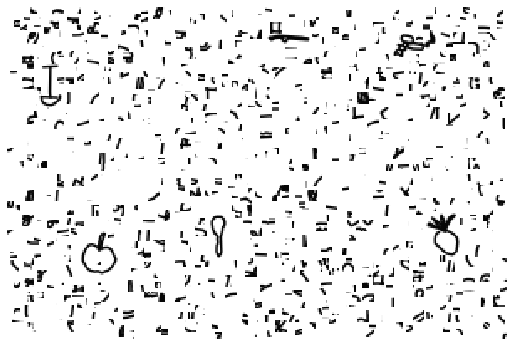

In [9]:
# Plot 6 different pictures
plt.figure(figsize = (9,9))
pre.plot_digits( X[:6] )
encoder.inverse_transform(Y[:6])